# Generate Segment PSFs for OTE-01 Data

In [2]:
import datetime
import warnings
from astropy.io import fits
import webbpsf
import numpy as np
import pprint
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Email from Marshall:
- Create 18 independent segment PSFs centered on each segment, each with some suitably small size rather than gigantic: 
    - Apply random perturbations as you are doing. 
    - For each segment, cut out just that segment from the OPD map (using the one_segment_pupil helper function in WebbPSF).
    - This part’s somewhat tricky. For each segment we will want to record what the tip/tilt  is, then zero it out before creating the PSF (so that we get the PSF centered on where the segment is). We can use the tip/tilt values in the OPD to compute the equivalent vector to where that PSF would be. 
    - End result should be 18 separate PSF arrays, plus for each one a tip/tilt vector saying where that should appear relative to the center of the PSF array.
 - Iterate over the list of targets in MIRAGE
- For each target, iterate over the list of 18 PSFs and their offsets. 
- Compute the apparent location of that PSF as the sum of the coordinates that star would normally have in the field of view plus the offset to that PSF.
- If that PSF falls inside the detector field of view somewhere, put it there. Otherwise, skip that PSF. 

## The way that works!

In [41]:
nc = webbpsf.NIRCam()
nc, ote = webbpsf.enable_adjustable_ote(nc)

In [32]:
# Generate the OPD with the deployment errors
def apply_deployment_errors(ote, deployment_errors):
    ote.reset()
    ote.remove_piston_tip_tilt = False # Reset this
    
    print(deployment_errors['sm_piston'])
    # Add SM moves
    ote.move_sm_local(
        piston=deployment_errors['sm_piston'], xtilt=deployment_errors['sm_tilt'][0],
        ytilt=deployment_errors['sm_tilt'][1], xtrans=deployment_errors['sm_decenter'][0],
        ytrans=deployment_errors['sm_decenter'][1])

    # Add PMSA (segment) moves
    for i, seg in enumerate(ote.segnames[0:18]):
        ote.move_seg_local(
            seg,
            piston=deployment_errors['pm_piston'][i] + deployment_errors['global_pm_piston'],
            xtilt=deployment_errors['pm_tilt'][i][0] + deployment_errors['global_pm_tilt'][0],
            ytilt=deployment_errors['pm_tilt'][i][1] + deployment_errors['global_pm_tilt'][1],
            xtrans=deployment_errors['pm_decenter'][i][0] + deployment_errors['global_pm_decenter'][0],
            ytrans=deployment_errors['pm_decenter'][i][1] + deployment_errors['global_pm_decenter'][1],
            roc=deployment_errors['pm_roc'][i],
            clocking=deployment_errors['pm_clocking'][i] + deployment_errors['global_pm_clocking']
        )
        
    ote.update_opd()
    return ote

In [43]:
# Randomly generate a expected deployment tolerances.
# Deployment tolerances taken from JWST WFS&C Commissioning and Operations Plan (OTE-24):
# D36168 / 2299462 Rev C Page 10

deployment_errors = {
    'sm_piston': np.random.normal(loc=0, scale= 2500/5),  # microns
    'sm_piston': np.random.normal(loc=0, scale= 2500/5),  # microns
    'sm_tilt': np.random.normal(loc=0, scale= 1300/5, size=2),  # microradians
    'sm_decenter': np.random.normal(loc=0, scale= 2500/5, size=2),  # microns
    'pm_piston': np.random.normal(loc=0, scale= 1500/5, size=18),  # microns
    'pm_tilt': np.random.normal(loc=0, scale= 1100/5, size=(18, 2)),  # microradians
    'pm_decenter': np.random.normal(loc=0, scale= 1300/5, size=(18, 2)),  # microns
    'pm_roc' : np.random.normal(loc=0, scale= 151/5, size=(18)),  # microns
    'pm_clocking' : np.random.normal(loc=0, scale= 1200/5, size=(18)),  # microradians
    'global_pm_piston' : np.random.normal(loc=0, scale= 700/5),  # microns
    'global_pm_tilt' : np.random.normal(loc=0, scale= 190/5, size=2),  # microradians
    'global_pm_decenter' : np.random.normal(loc=0, scale= 200/5, size=2),  # microns
    'global_pm_clocking' : np.random.normal(loc=0, scale= 150/5),  # microradians
}
# pprint.pprint(deployment_errors)

107.42697502026505


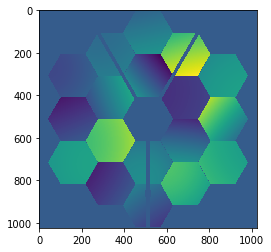

Segment poses in Control coordinates: (microns for decenter & piston, microradians for tilts and clocking):
  	      Xtilt      Ytilt     Piston   Clocking     Radial        ROC
A1	   -20.1446    -8.1322    43.7875   -61.3183   -32.5894   -13.3583
A2	   -31.8970   -77.0869     7.9905    24.8193    -7.0009    -3.4030
A3	    -7.6189    -7.4665   -37.2684    -2.8526   -30.9193     3.2363
A4	    61.6572    74.9740   -10.0246    74.6585    29.5581     1.9479
A5	    50.2762   -53.1828    37.6887    63.1503   -42.7883    -3.0971
A6	    30.0823    14.8428   132.3277   -16.4140   -53.3483     7.2827
B1	   -36.5153    28.9097     1.0421   -53.7891    68.4294     3.7806
C1	     9.6776    33.1402   101.8635    60.8802   -54.0649   -10.1607
B2	   -11.4332    19.7652    90.8387   -13.6551   -34.7724     3.9113
C2	   -67.6171    77.2065    93.2719   -20.7767   -43.7032     2.2730
B3	     1.6084    16.6324    69.3345    10.1591   -78.8186    -4.0163
C3	    47.7326    44.7131   152.4997   -57.3040    3

In [102]:
# Use 20% of the full deployment errors
reduced_deployment_errors = {}
for key, value in deployment_errors.items():
    reduced_deployment_errors[key] = value * 0.2
    
ote_reduced = apply_deployment_errors(ote, reduced_deployment_errors)
plt.imshow(ote_reduced.opd)
plt.show()
ote_reduced.print_state()
ote = ote_reduced

In [103]:
# Save segment tilt to a list
segment_tilts = np.copy(ote.segment_state[:, :2])

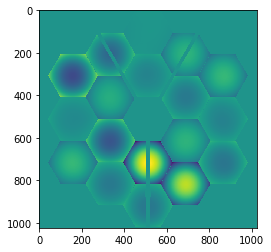

Segment poses in Control coordinates: (microns for decenter & piston, microradians for tilts and clocking):
  	      Xtilt      Ytilt     Piston   Clocking     Radial        ROC
A1	     0.0000     0.0000     0.0000   -61.3183   -32.5894   -13.3583
A2	     0.0000     0.0000     0.0000    24.8193    -7.0009    -3.4030
A3	     0.0000     0.0000     0.0000    -2.8526   -30.9193     3.2363
A4	     0.0000     0.0000     0.0000    74.6585    29.5581     1.9479
A5	     0.0000     0.0000     0.0000    63.1503   -42.7883    -3.0971
A6	     0.0000     0.0000     0.0000   -16.4140   -53.3483     7.2827
B1	     0.0000     0.0000     0.0000   -53.7891    68.4294     3.7806
C1	     0.0000     0.0000     0.0000    60.8802   -54.0649   -10.1607
B2	     0.0000     0.0000     0.0000   -13.6551   -34.7724     3.9113
C2	     0.0000     0.0000     0.0000   -20.7767   -43.7032     2.2730
B3	     0.0000     0.0000     0.0000    10.1591   -78.8186    -4.0163
C3	     0.0000     0.0000     0.0000   -57.3040    3

In [105]:
# Remove the piston/tip/tilt
ote.remove_piston_tip_tilt = True
# So it seems like update_opd() doesn't update the segment_state?

# That doesn't seem to work, so manually zero out the piston/tip/tilt
for segment in range(18):
    ote.segment_state[segment, :3] = 0
ote.update_opd()

plt.imshow(ote.opd)
plt.show()
ote.print_state()

Completed segment 1
Completed segment 2
Completed segment 3
Completed segment 4
Completed segment 5
Completed segment 6
Completed segment 7
Completed segment 8
Completed segment 9
Completed segment 10
Completed segment 11
Completed segment 12
Completed segment 13
Completed segment 14
Completed segment 15
Completed segment 16
Completed segment 17
Completed segment 18


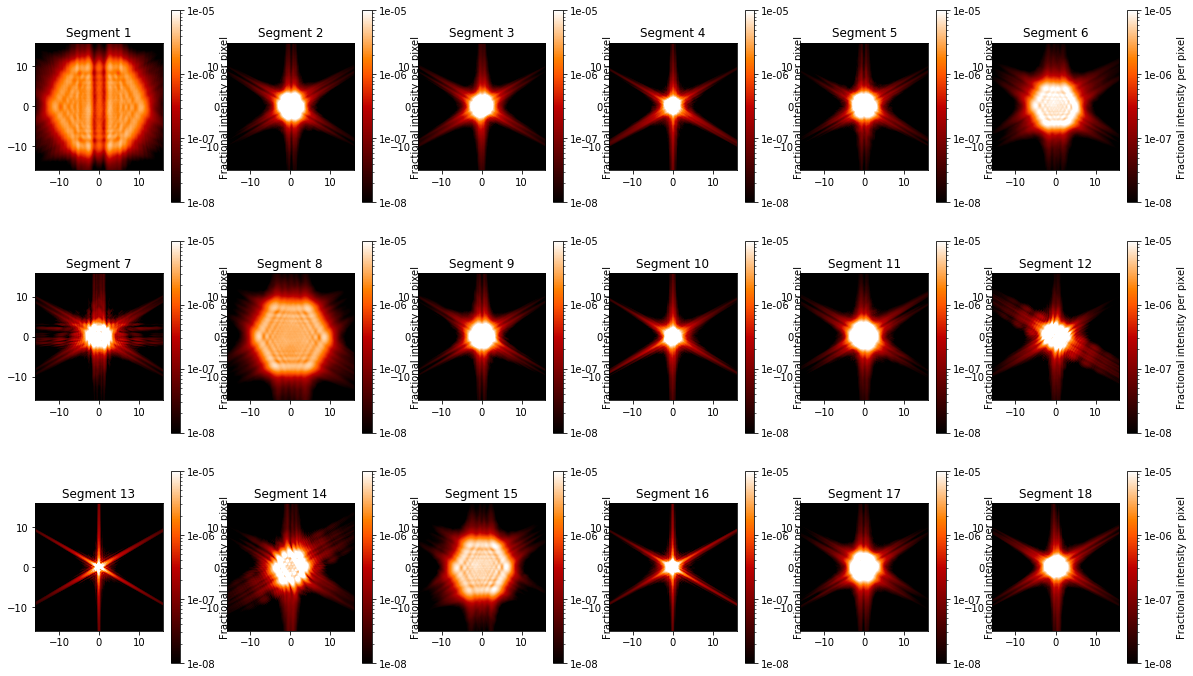

In [108]:
# Generate and save 18 segment PSFs
fig, ax_array = plt.subplots(3, 6, figsize=(20, 12))

for i in range (18):
    i_row = i // 6
    i_column = i % 6
    ax = ax_array[i_row, i_column]

    # Restrict the pupil to the current segment
    i_segment = i + 1
    pupil = webbpsf.webbpsf_core.one_segment_pupil(i_segment)
    ote.amplitude = pupil[0].data

    # Calculate and display the PSF
    fov_pixels = 1024
    psf = nc.calc_psf(nlambda=30, oversample=1, fov_pixels=fov_pixels, add_distortion=False)
    webbpsf.display_psf(psf, vmin=1e-8, vmax=1e-5, ax=ax, title='Segment {}'.format(i+1))
    
    # Save the PSF to a FITS file
    now = datetime.datetime.now()
    psf_filename = "../OTECommissioning/OTE01/PSFs/{:2d}{:2d}{:2d}-{:2d}{:2d}{:2d}-OTE01_segment{}_PSF.fits".format(
        now.year, now.month, now.day, now.hour, now.minute, now.second, i_segment
    )
    data = psf[1].data
    hdr = psf[1].header

    # Add header keywords about segment
    hdr['SEGID'] = (i_segment, 'ID of the mirror segment')
    hdr['XTILT'] = (round(segment_tilts[i, 0], 2), 'X tilt of the segment in microns')
    hdr['YTILT'] = (round(segment_tilts[i, 1], 2), 'Y tilt of the segment in microns')

    fits.writeto(psf_filename, data, header=hdr)
    print('Completed segment {}'.format(i + 1))
    
now = datetime.datetime.now()
plot_filename = "{:4d}{:02d}{:02d}-{:02d}{:02d}{:02d}-OTE01_model_normal_20%_PSFs.jpg".format(
    now.year, now.month, now.day, now.hour, now.minute, now.second, i_segment
)
plt.savefig(plot_filename)
plt.show()

## Experimenting

In [3]:
nc = webbpsf.NIRCam()
nc, ote = webbpsf.enable_adjustable_ote(nc)

In [15]:
# Randomly generate a expected deployment tolerances.
# Deployment tolerances taken from JWST WFS&C Commissioning and Operations Plan (OTE-24):
# D36168 / 2299462 Rev C Page 10

deployment_errors = {
    'sm_piston': np.random.normal(loc=0, scale= 2500/5),  # microns
    'sm_piston': np.random.normal(loc=0, scale= 2500/5),  # microns
    'sm_tilt': np.random.normal(loc=0, scale= 1300/5, size=2),  # microradians
    'sm_decenter': np.random.normal(loc=0, scale= 2500/5, size=2),  # microns
    'pm_piston': np.random.normal(loc=0, scale= 1500/5, size=18),  # microns
    'pm_tilt': np.random.normal(loc=0, scale= 1100/5, size=(18, 2)),  # microradians
    'pm_decenter': np.random.normal(loc=0, scale= 1300/5, size=(18, 2)),  # microns
    'pm_roc' : np.random.normal(loc=0, scale= 151/5, size=(18)),  # microns
    'pm_clocking' : np.random.normal(loc=0, scale= 1200/5, size=(18)),  # microradians
    'global_pm_piston' : np.random.normal(loc=0, scale= 700/5),  # microns
    'global_pm_tilt' : np.random.normal(loc=0, scale= 190/5, size=2),  # microradians
    'global_pm_decenter' : np.random.normal(loc=0, scale= 200/5, size=2),  # microns
    'global_pm_clocking' : np.random.normal(loc=0, scale= 150/5),  # microradians
}
pprint.pprint(deployment_errors)

{'global_pm_clocking': 52.82756424450799,
 'global_pm_decenter': array([ 54.7432137 , -26.54943057]),
 'global_pm_piston': -76.77812886411932,
 'global_pm_tilt': array([-31.58399109, -22.67106569]),
 'pm_clocking': array([ -37.70578393,   26.48757669,  -21.85302563, -211.92281805,
        233.45081739,   75.02804025,   58.50811825,  197.2749474 ,
         -3.55331161,   98.35605195, -136.20925997,  109.03928278,
         74.02051567,  288.73026385,  322.13254492, -269.62577058,
       -402.3507674 , -196.00481892]),
 'pm_decenter': array([[ 275.26752398,  560.97252951],
       [ 197.24778121,  136.9360872 ],
       [ 193.44384397,  -57.16042501],
       [ 605.31834213,  187.64916753],
       [  18.01291737, -250.65314415],
       [ 352.13703287,   31.75357213],
       [ -42.35990906, -252.50694313],
       [  34.60623519, -209.57005606],
       [ 133.05600839,  125.77160421],
       [  62.05782607,  -33.748637  ],
       [-141.00906768,    8.22714284],
       [  90.12502058, -459.59610

-70.01498077675005


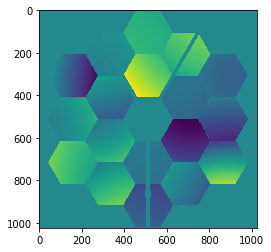

Segment poses in Control coordinates: (microns for decenter & piston, microradians for tilts and clocking):
  	      Xtilt      Ytilt     Piston   Clocking     Radial        ROC
A1	    59.0477   -27.7187  -107.2436    15.1218  -534.4231    -0.3289
A2	   -68.7224  -209.3423  -482.1818    79.3151  -110.3867    55.3401
A3	    -1.8424    61.1431  -139.4658    30.9745    83.7099   -29.2881
A4	   211.1096   217.0317   459.2538  -159.0953  -161.0997    29.1106
A5	  -190.8159  -176.4117   -66.1339   286.2784   277.2026    -6.7439
A6	   -47.1646   292.3274    85.4015   127.8556    -5.2041    46.2258
B1	    72.4235    50.1625  -265.1154   111.3357  -279.0564     6.9824
C1	   107.3272   192.5880   -75.4511   250.1025    89.3494   -16.8888
B2	   366.0460   584.8188    99.0838    49.2743    99.2222   -56.2140
C2	  -298.7615     9.1669  -288.6458   151.1836   116.8010    34.7641
B3	   -52.4590   -39.9855  -177.6051   -83.3817   -18.3223    50.7490
C3	    26.6536  -179.0885   300.1726   161.8668   14

In [17]:
# NEW: Record the tip/tilt
ote = apply_deployment_errors(ote, deployment_errors)
plt.imshow(ote.opd)
plt.show()
ote.print_state()

-14.002996155350012


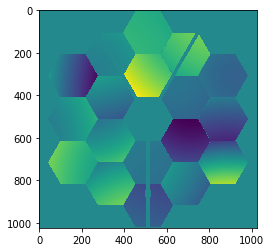

Segment poses in Control coordinates: (microns for decenter & piston, microradians for tilts and clocking):
  	      Xtilt      Ytilt     Piston   Clocking     Radial        ROC
A1	    11.8095    -5.5437   -21.4487     3.0244  -106.8846    -0.0658
A2	   -13.7445   -41.8685   -96.4364    15.8630   -22.0773    11.0680
A3	    -0.3685    12.2286   -27.8932     6.1949    16.7420    -5.8576
A4	    42.2219    43.4063    91.8508   -31.8191   -32.2199     5.8221
A5	   -38.1632   -35.2823   -13.2268    57.2557    55.4405    -1.3488
A6	    -9.4329    58.4655    17.0803    25.5711    -1.0408     9.2452
B1	    14.4847    10.0325   -53.0231    22.2671   -55.8113     1.3965
C1	    21.4654    38.5176   -15.0902    50.0205    17.8699    -3.3778
B2	    73.2092   116.9638    19.8168     9.8549    19.8444   -11.2428
C2	   -59.7523     1.8334   -57.7292    30.2367    23.3602     6.9528
B3	   -10.4918    -7.9971   -35.5210   -16.6763    -3.6645    10.1498
C3	     5.3307   -35.8177    60.0345    32.3734    2

In [37]:
reduced_deployment_errors = {}
for key, value in deployment_errors.items():
    reduced_deployment_errors[key] = value * 0.2
    
ote_reduced = apply_deployment_errors(ote, reduced_deployment_errors)
plt.imshow(ote_reduced.opd)
plt.show()
ote_reduced.print_state()

In [38]:
ote = ote_reduced

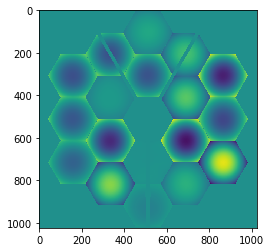

Segment poses in Control coordinates: (microns for decenter & piston, microradians for tilts and clocking):
  	      Xtilt      Ytilt     Piston   Clocking     Radial        ROC
A1	     0.0000     0.0000     0.0000     3.0244  -106.8846    -0.0658
A2	     0.0000     0.0000     0.0000    15.8630   -22.0773    11.0680
A3	     0.0000     0.0000     0.0000     6.1949    16.7420    -5.8576
A4	     0.0000     0.0000     0.0000   -31.8191   -32.2199     5.8221
A5	     0.0000     0.0000     0.0000    57.2557    55.4405    -1.3488
A6	     0.0000     0.0000     0.0000    25.5711    -1.0408     9.2452
B1	     0.0000     0.0000     0.0000    22.2671   -55.8113     1.3965
C1	     0.0000     0.0000     0.0000    50.0205    17.8699    -3.3778
B2	     0.0000     0.0000     0.0000     9.8549    19.8444   -11.2428
C2	     0.0000     0.0000     0.0000    30.2367    23.3602     6.9528
B3	     0.0000     0.0000     0.0000   -16.6763    -3.6645    10.1498
C3	     0.0000     0.0000     0.0000    32.3734    2

In [39]:
# Remove the piston/tip/tilt
ote.remove_piston_tip_tilt = True
# ote.update_opd()
# So it seems like update_opd() doesn't update the segment_state?

# That doesn't seem to work, so manually zero out the piston/tip/tilt
for segment in range(18):
    ote.segment_state[segment, :3] = 0
ote.update_opd()

plt.imshow(ote.opd)
plt.show()
ote.print_state()

/Users/lchambers/miniconda3/envs/mirage/lib/python3.6/site-packages/poppy/instrument.py:629: UserWarning: For wavelength 1.749 microns, a FOV of 63.693 * 63.693 arcsec exceeds the maximum  spatial frequency well sampled by the input pupil. Your computed PSF will suffer from aliasing for angles beyond 27.968 arcsec radius.
  wl * 1e6, det_fov_arcsec[0], det_fov_arcsec[1], critical_angle_arcsec))
/Users/lchambers/miniconda3/envs/mirage/lib/python3.6/site-packages/poppy/instrument.py:629: UserWarning: For wavelength 1.766 microns, a FOV of 63.693 * 63.693 arcsec exceeds the maximum  spatial frequency well sampled by the input pupil. Your computed PSF will suffer from aliasing for angles beyond 28.235 arcsec radius.
  wl * 1e6, det_fov_arcsec[0], det_fov_arcsec[1], critical_angle_arcsec))
/Users/lchambers/miniconda3/envs/mirage/lib/python3.6/site-packages/poppy/instrument.py:629: UserWarning: For wavelength 1.782 microns, a FOV of 63.693 * 63.693 arcsec exceeds the maximum  spatial frequen

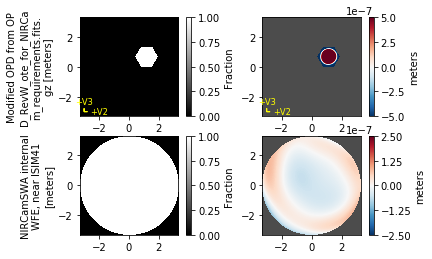

In [106]:
# Generate the PSF for a single segment pupil
i_segment = 2
pupil = webbpsf.webbpsf_core.one_segment_pupil(i_segment)
ote.amplitude = pupil[0].data

# Calculate the PSF
now = datetime.datetime.now()
psf_filename = "{:2d}{:2d}{:2d}-{:2d}{:2d}{:2d}-OTE01_segment{}_PSF.fits".format(
    now.year, now.month, now.day, now.hour, now.minute, now.second, i_segment
)

fov_pixels = 2048
psf = nc.calc_psf(nlambda=30, oversample=1, fov_pixels=fov_pixels, add_distortion=False,
            outfile=psf_filename)
nc.display()

Completed segment 1
Completed segment 2
Completed segment 3
Completed segment 4
Completed segment 5
Completed segment 6
Completed segment 7
Completed segment 8
Completed segment 9
Completed segment 10
Completed segment 11
Completed segment 12
Completed segment 13
Completed segment 14
Completed segment 15
Completed segment 16
Completed segment 17
Completed segment 18


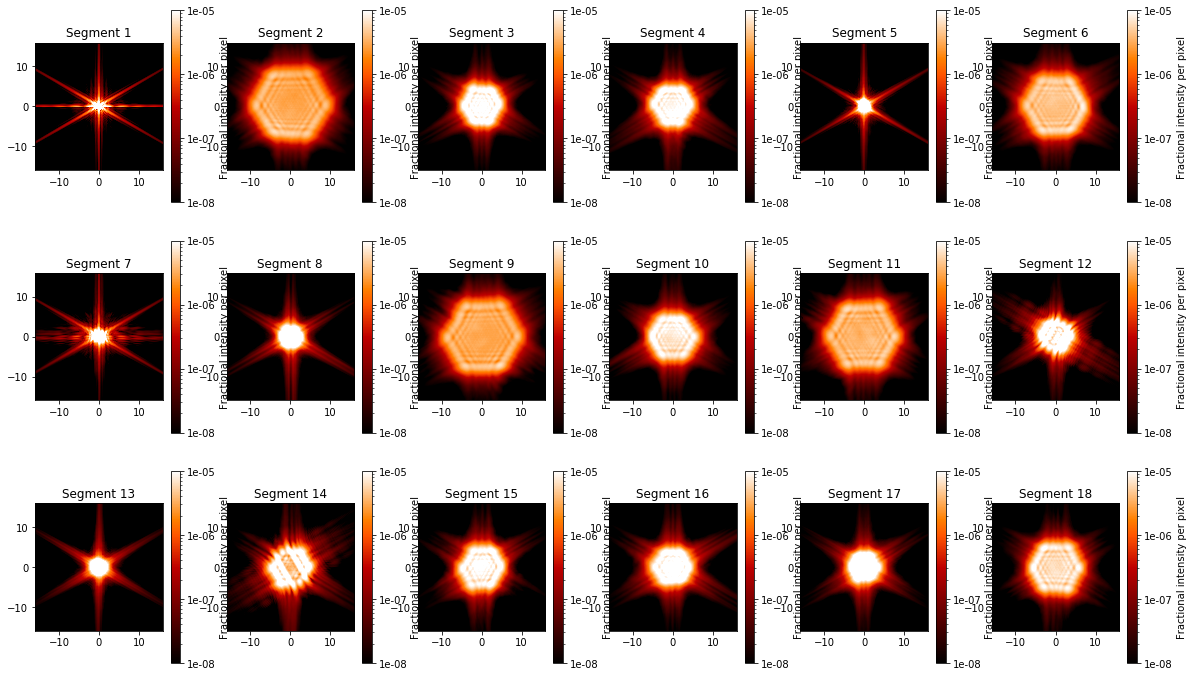

In [40]:
# Look at all 18 segments....
fig, ax_array = plt.subplots(3, 6, figsize=(20, 12))

for i in range (18):
    i_row = i // 6
    i_column = i % 6
    ax = ax_array[i_row, i_column]

    # Restrict the pupil to the current segment
    i_segment = i + 1
    pupil = webbpsf.webbpsf_core.one_segment_pupil(i_segment)
    ote.amplitude = pupil[0].data

    # Calculate and display the PSF
    fov_pixels = 1024
    psf = nc.calc_psf(nlambda=30, oversample=1, fov_pixels=fov_pixels, add_distortion=False)
    webbpsf.display_psf(psf, vmin=1e-8, vmax=1e-5, ax=ax, title='Segment {}'.format(i+1))
    print('Completed segment {}'.format(i + 1))
    

now = datetime.datetime.now()
plot_filename = "{:2d}{:2d}{:2d}-{:2d}{:2d}{:2d}-OTE01_model_normal_20%_PSFs.jpg".format(
    now.year, now.month, now.day, now.hour, now.minute, now.second, i_segment
)
plt.savefig(plot_filename)
plt.show()

# Example: Generate PSF for just one segment

In [ ]:
nc = webbpsf.NIRCam()
nc, ote = webbpsf.enable_adjustable_ote(nc)
webbpsf.opds.setup_image_array(ote, size='large', reset=True, verbose=False)
psf = nc.calc_psf(nlambda=1, display=True, fov_pixels=2048)

/Users/lchambers/miniconda3/envs/mirage/lib/python3.6/site-packages/poppy/instrument.py:629: UserWarning: For wavelength 1.991 microns, a FOV of 63.693 * 63.693 arcsec exceeds the maximum  spatial frequency well sampled by the input pupil. Your computed PSF will suffer from aliasing for angles beyond 31.846 arcsec radius.
  wl * 1e6, det_fov_arcsec[0], det_fov_arcsec[1], critical_angle_arcsec))


In [ ]:
webbpsf.display_psf(psf, vmin=1e-12)

In [71]:
pupil = webbpsf.webbpsf_core.one_segment_pupil('A3')
# psf = nc.calc_psf(nlambda=1, display=True)
# plt.imshow(pupil[0].data)

In [72]:
ote.amplitude = pupil[0].data

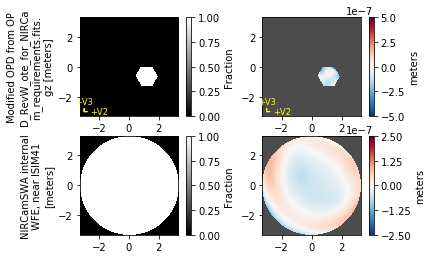

In [73]:
nc.display()

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x104fd40b8>, <astropy.io.fits.hdu.image.ImageHDU object at 0x104fd4048>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1c1b73edd8>]

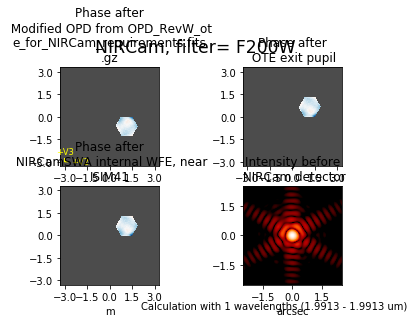

In [74]:
nc.calc_psf(nlambda=1, display=True)

# Generate segment PSF for telescope in image array

In [22]:
%%time
# Generate a PSF with a perturbed OTE according to the expected deployment tolerances.
# Deployment tolerances taken from JWST WFS&C Commissioning and Operations Plan (OTE-24):
# D36168 / 2299462 Rev C Page 10

nc = webbpsf.NIRCam()
# nc.filter = 'F212N'
nc, ote = webbpsf.enable_adjustable_ote(nc)

# *** QUESTION: Do I want to pull these random values from a normal distribution? ***

# Add SM moves
random_sm_piston = np.random.random(1) * 5000 - 2500 # microns
random_sm_tilt = np.random.random(2) * 2600 - 1300 # microradians
random_sm_decenter = np.random.random(2) * 5000 - 2500 # microns

ote.move_sm_local(piston=random_sm_piston, xtilt=random_sm_tilt[0], 
                  ytilt=random_sm_tilt[1], xtrans=random_sm_decenter[0],
                  ytrans=random_sm_decenter[1])  

# Add PMSA (segment) moves
random_pm_piston = np.random.random(18) * 3000 - 1500 # microns
random_pm_tilt = np.random.random((18, 2)) * 2200 - 1100 # microradians
random_pm_decenter = np.random.random((18, 2)) * 2600 - 1300 # microns
random_pm_roc = np.random.random(18) * 302 - 151 # microns
random_pm_clocking = np.random.random(18) * 2400 - 1200 # microradians

global_pm_piston = np.random.random(1) * 1400 - 700 # microns
global_pm_tilt = np.random.random(2) * 380 - 190 # microradians
global_pm_decenter = np.random.random(2) * 400 - 200 # microns
global_pm_clocking = np.random.random(1) * 300 - 150 # microradians

for i, seg in enumerate(ote.segnames[0:18]):
    ote.move_seg_local(seg, 
                       piston=random_pm_piston[i] + global_pm_piston,
                       xtilt=random_pm_tilt[i][0] + global_pm_tilt[0], 
                       ytilt=random_pm_tilt[i][1] + global_pm_tilt[1], 
                       xtrans=random_pm_decenter[i][0] + global_pm_decenter[0], 
                       ytrans=random_pm_decenter[i][1] + global_pm_decenter[1], 
                       roc=random_pm_roc[i], 
                       clocking=random_pm_clocking[i] + global_pm_clocking)

CPU times: user 50.8 s, sys: 6.54 s, total: 57.4 s
Wall time: 15.6 s


(<matplotlib.axes._subplots.AxesSubplot at 0x1c21072d68>,
 <matplotlib.colorbar.Colorbar at 0x10af227b8>)

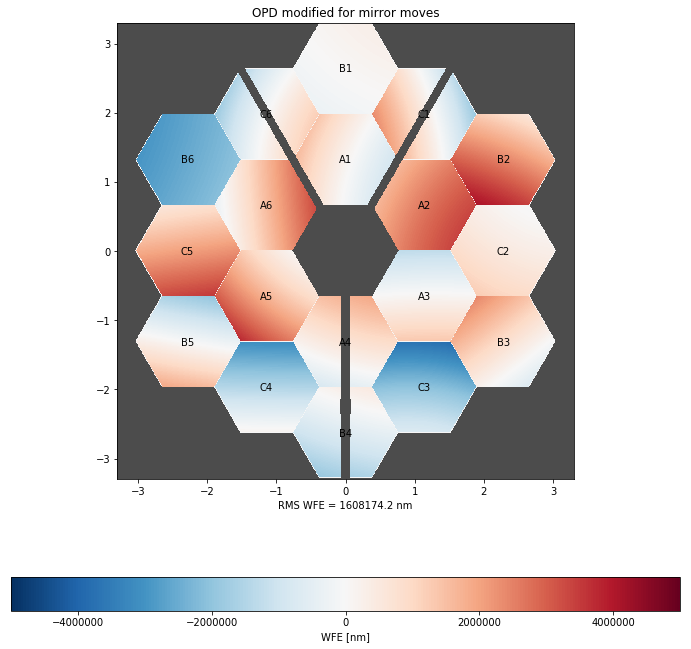

In [23]:
# Plot the OPD
plt.figure(figsize=(12,12))
ax1=plt.subplot(111)
ote.display_opd(ax=ax1, vmax=5e6, 
                colorbar_orientation='horizontal',
               title='OPD modified for mirror moves') #, cbpad=0.05)

In [24]:
# Save the OPD as a FITS file
now = datetime.datetime.now()
ote_filename = "{:4d}{:02d}{:02d}-{:02d}{:02d}{:02d}-OTE01_perturbedOTE.fits".format(now.year, now.month, now.day, now.hour, now.minute, now.second)
print(ote_filename)
hdulist = fits.HDUList(hdus=ote.as_fits())
hdulist.writeto(ote_filename, output_verify='ignore')

20181029-171434-OTE01_perturbedOTE.fits


In [25]:
# Generate the PSF and save it as a file, too
now = datetime.datetime.now()
psf_filename = "{:2d}{:2d}{:2d}-{:2d}{:2d}{:2d}-OTE01_PSF.fits".format(now.year, now.month, now.day, now.hour, now.minute, now.second)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    %time ga_psf = nc.calc_psf(nlambda=30, oversample=1, fov_pixels=500, add_distortion=False, outfile=psf_filename)#, display=True)

CPU times: user 28.3 s, sys: 1.88 s, total: 30.2 s
Wall time: 8.03 s


In [14]:
ga_psf.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     133   (500, 500)   float64   
  1  DET_SAMP      1 ImageHDU       134   (500, 500)   float64   


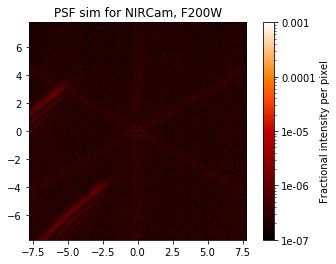

In [15]:
ax = webbpsf.display_psf(ga_psf, return_ax=True, vmin=1e-7, vmax=1e-3)
# ax = ax[0]
# ax.set_xlim(0, 20)
# ax.set_ylim(0, -20)

In [56]:
ga_psf.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     150   (500, 500)   float64   
  1  DET_SAMP      1 ImageHDU       152   (500, 500)   float64   
  2  OVERDIST      1 ImageHDU       196   (500, 500)   float64   
  3  DET_DIST      1 ImageHDU       197   (500, 500)   float64   


In [59]:
hdulist = fits.HDUList(ga_psf[1])
hdulist.writeto('OTE01_PSF_DET_SAMP.fits', output_verify='ignore')

In [27]:
pupil = webbpsf.webbpsf_core.one_segment_pupil(1)

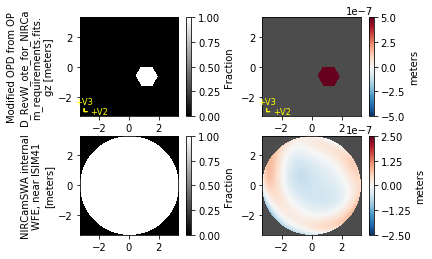

In [31]:
# Restrict the pupil to just be one segment
pupil = webbpsf.webbpsf_core.one_segment_pupil('A3')
ote.amplitude = pupil[0].data
nc.display()

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    %time ga_a3_psf = nc.calc_psf(nlambda=30, oversample=1, fov_pixels=1e4)#, display=True)

In [ ]:
ax = webbpsf.display_psf(ga_a3_psf, return_ax=True, vmin=1e-20, vmax=1e-4)
# ax = ax[0]
# ax.set_xlim(0, 20)
# ax.set_ylim(0, -20)

In [29]:
np.arange(1, 19)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18])